# Introduction

The act of observing distant stars and galaxies has challenged astronomers for centuries. And as a result, astronomers have historically been extremely good at coming up with clever tricks for maximizing the information conent of low signal-to-noise (S/N) data. For example, in order to properly measure the stellar mass of a galaxy, you need at least $\sim$10 broad-band images of a galaxy across a wide wavelength range. This sort of dataset is often difficult to come by and thus, many studies use a sigle magnitude and a simple scaling relation to convert from a magnitude to a stellar-mass. 

Another instance where astronomers overcome a lack of high-quality data is when trying to characterize a population of galaxies (or stars) using spectroscopy. In this case, when the individual spectra do not have sufficient S/N, it is common to "stack" all of the spectra together to make a single, high-S/N, averaged spectrum. This will boost the S/N by a factor of $\sqrt{N}$ where $N$ is the number of objects. Thus, if a S/N $\sim$15 is required to make a meaningful metallicity measurement, and each individual spectrum has a S/N $=2$, there is no hope for constraining metallicity of each individual object. However, by stacking $N\gtrsim50$ objects, the metallicity of the population of objects can be measured by stacking. This method of "stacking" (of both spectra and photometry) has been been used for decades to boost data quality when individual data fall short. 

My thesis project lives on the edge of what is currently possible with the available telescopes and instruments, and thus I rely on these sort of "hacks" to boost the information content of the data I work with. For example, I have a sample of $N\sim130$ quiescent galaxy spectra at $z\sim0.7$. Each spectrum has a S/N $\sim20$. These ultra-deep spectra are more than sufficient to measure things like the metallicity and ages of each galaxy. However, I am also interested in their elemental abudnances -- e.g., what is the $\alpha$ enhancement of these galaxies, and how does it vary with stellar mass? Furthermore, which elements are $\alpha$-elements at this redshift? And which are Fe-peak? In order to answer these questions, I need to measure the elemental abundances of e.g., Mg, Ti, Ca, Si, Co, and C, which require much higher S/N than 20 because the absorption feautres vary on only a few percent level. Even with the high-S/N of $z\sim0$ galaxies, these measurements are hard to make! And as a result, most studies at $z\sim0$ rely on stacking.

One shortcoming of the "stacking" method is that it introduces a lot of systematic uncertainties. In order to stack the spectra, it is necessary to continuum normalized by fitting a high-order polynomial, smoothing the spectrum to the same velocity dispersion, interpolating it onto a global wavelength grid, and finally combining the spectra via a weighted sum. Each of these steps introduces a different type of systematic uncertainty; fitting a polynomial to a spectrum runs the risk of removing part of the absorption features by overfitting, smoothing introduces correlated noise and reduces the information content of the spectrum, linear interpolation does a poor job at conserving the noise level, and the parameter used for weighing the spectrum will result in different results (e.g., light-weighted v.s. mass-weighted v.s. age-weighted v.s. no weight).

The systematic uncertainties introduced by the above weighing techniques tends to be much larger than a few percent, and are thus insufficient for measureing elemental abundances.


# Hierarchical Bayesian Modeling

In the new age of big data astronomy, many fields are relying on more advanced statistical methods to make difficult measurements. These tools have paved the way for a whole new set of "tricks" to maximize the information conent of low S/N data. One such method, common in big-data cosmological surveys, is hierarchical bayesian modeling. In this method, every observation can be fit simulataneously to constrain a global parameter. In my case, where the goal is to measure the elemental abundances for a population of galaxies, I can forego all of the systematics involved in "stacking" (described above) by fitting in a hierarchical framework. In this fremework, I define a model where the first "layer" fits for the elemental abundances of individual galaxies and the second "layer" fits for the global distribution of these parameters.

In my specific problem, I have already spent (many) CPU hours computing the MCMC chains for the individual galaxies, and thus, to avoid even more computing, and to avoid re-writing the large modeling code, below I derive hierarchical Bayes for post-processing (using the chains I've already computed). 

### Background

Since this is a "Bayesian" method, here is the obligatory Bayes' theorem:

$$
P(\theta | X) = \frac{P(X|\theta)\cdot P(\theta)}{P(X)}
$$

Where $\theta$ are the parameters we wish to constrain, and X is the data. The left hand side is the probability of the parameters given the data, also known and the posterior. The first term on the right-hand-side is the likelihood, the second term is the prior on the parameters and the denominator is the probability of the data, or the "evidence" or "marginal likelihood" or "Bayes' integral" (a normalizing constant).

In the hierarchical framework, where $\alpha$ is the global parameters,

$$
P(\theta, \alpha | X) = \frac{P(X | \alpha, \theta)\cdot P(\alpha)\cdot P(\theta)}{P(X)}
$$

Or, expanded using the chain rule,

$$
P(\theta, \alpha | X) = \frac{P(X | \theta) \cdot P(\theta | \alpha)\cdot P(\alpha)\cdot P(\theta)}{P(X)}
$$

In a simple model, the left-hand-side can be constrained analytically by simply multiplying the functions on the right-hand-side together and then computing the weighted mean using an integral. Unfortunately, in many (most) cases, this integral cannot be analytically derived and thus we must sample the distribution on the right to get a discrete sampleing of the posterior. This sampling can be done with the tried and true Markov Chain Monte Carlo (MCMC) method. 

Mathematically speaking, this looks like the following:

Given a $p(\theta)$, we can generate expectation values, or the mean of $\theta$ under the PDF (weighted average):

$$
E_{p(\theta)}[\theta] = \int\theta \,p(\theta)\,d\theta
$$

or if interested in a function that depends on $\theta$

$$
E_{p(\theta)}[g(\theta)] = \int g(\theta) \,p(\theta)\,d\theta
$$

If we have individual samples from $p(\theta)$, we can replace the integral with a sum over the $K$ samples:

$$
E_{p(\theta)}[\theta] \approx \frac{1}{K} \sum_{k=1}^{K} \theta_k
$$

$$
E_{p(\theta)}[g(\theta)] \approx \frac{1}{K} \sum_{k=1}^{K} g(\theta_k)
$$

So $p(\theta)$ is hard to compute. Often we can only compute $f(\theta)$, where $f(\theta) = p(\theta)\cdot Z$. That is, $f(\theta)$ is the likelihood times the prior and $Z$ is the "evidence." In this case....

$$
E_{p(\theta)}[g(\theta)] = \frac{\int g(\theta) \,f(\theta)\,d\theta}{\int f(\theta)\,d\theta}
$$

(where the denominator is the complex normalizing constant $Z$). Again, with good sampling of $\{\theta_k\}_{k=1}^{K}$, we can reduce this to:

$$
E_{p(\theta)}[g(\theta)] \approx \frac{1}{K} \sum_{k=1}^{K} g(\theta_k)
$$

Thus, by evaluating $f(\theta)$ directly using sampling, we can avoid doing the nasty integrals!!


### ok moving onto our situation...

Below I derive a general approach to applying Hierarchical Bayes in post-processing. At the very end I describe how this works in practice.

First, let's re-write Hierarchical Bayes' Theorem using problem-specific variables
$$
P(\{X_n\},\theta | \{S_n\}) = \frac{P(\theta)\,P(\{S_n\}|\theta,\{X_n\})}{P(\{S_n\})}
$$

Expand numerator...
$$
P(\{X_n\},\theta | \{S_n\}) = \frac{P(\theta)\,P(\{S_n\}|\{X_n\})\,P(\{X_n\}|\theta)}{P(\{S_n\})}
$$

Where $X_n$ is the measurement of a given label for the nth galaxy, $\theta$ is the population parameters I'm looking to constrain, $\{S_n\}$ is the set of spectra for all N galaxies. I will drop the brackets for the rest of this derivation.

Write this in integral form... 
$$
P(X_n,\theta | S_n) = \prod_{n=1}^{N}\int \frac{P(\theta)\,P(S_n|X_n)\,P(X_n|\theta)}{P(S_n)}\,dX_n
$$

If we assume uniform prior on $\theta$ and take $P(S_n)$ out of the integral because it does not depend on $X_n$, we get:
$$
P(X_n,\theta | S_n) = \frac{P(\theta)}{P(S_n)}\prod_{n=1}^{N}\int P(S_n|X_n)\,P(X_n|\theta)\,dX_n
$$

The first term in this integral is the probability of the spectrum given one of the labels. Using Bayes' Theorem, we can remove any dependence on the original spectra so that we can do post-processing with the inidividual chains. The output of these individual chains is:

$$
X_n^{(k)}\sim P(X_n|S_n,\alpha)
$$

We can now substitude Bayes' to the RHS:

$$
X_n^{(k)}\sim \frac{P(S_n|X_n)\,P(X_n|\alpha)}{P(S_n|\alpha)}
$$

For completeness, note that $P(S_n|X_n)$ is actually $P(S_n|X_n,\theta)$ but we assert that the spectra do not care about the popualtion parameters $\theta$ (e.g., galaxies don't talk to eachother).

We can now substitute $P(X_n|S_n)$

$$
P(S_n|X_n) = \frac{P(\{X_n\}|\{S_n\},\alpha)\,P(\{S_n\}|\alpha)}{P(\{X_n\}|\alpha)}
$$

$$
P(X_n,\theta | S_n) = \frac{P(\theta)}{P(S_n)}\prod_{n=1}^{N}\int \frac{P(X_n|S_n,\alpha)\,P(S_n|\alpha)}{P(X_n|\alpha)}\,P(X_n|\theta)\,dX_n
$$

$P(S_n|\alpha)$ doesn't depend on $X_n$. This can be removed from the integral. 

$$
P(X_n,\theta | S_n) =  \frac{P(S_n|\alpha)\,P(\theta)}{P(S_n)}\prod_{n=1}^{N}\int P(X_n|S_n,\alpha)\,\frac{P(X_n|\theta)}{P(X_n|\alpha)}\,dX_n
$$

Now, the first term in the integral is the posteriors from the individual fits and the second term is the population model.

So how do we implement this? Let's convert the integral to a sum given what we learned above through sampling:

$$
\int f(x)\,p(x)\approx \frac{1}{K}\sum_{k=1}^K f(x) \approx \frac{1}{K}\sum_{k=1}^K e^{\log f(x)}
$$

The right-hand-side of the above equation provides a way to avoid numerical errors when calculating the likelihood ("logsumexp" function).

In our case, $f(x) = \frac{P(X_n|\theta)}{P(X_n|\alpha)}$ (a.k.a the chains divided by the prior, which for most parameters is uniform). Also, let's take the log so we can convert the product into a summation (we can remove the $\frac{1}{K}$ from the sum):

$$
\log P(X_n,\theta | S_n) = \log P(S_n|\alpha) +\log P(\theta) - P(S_n) - \log K + \sum_{n=1}^N\log\left[\sum_{k=1}^K e^{\log f(x)}\right]
$$

The first term, $\log P(S_n|\alpha)$, is the interim evidence (see where $X_n^{(k)}$ is defined). This term is just some complicated normalizing constant and since we do not care about the relative probability scaling, it can be ignored (same goes for the third term, $\log P(S_n)$). The second term, $\log P(\theta)$ is the prior on the population parameters (which in our case we take to be constant so it goes to 1). 


### Actual implementation:

To calculate the posterior on the global parameters given the chains of individual fits, I need to evaluate the following: 

$$
\log P(X_n,\theta | S_n) \sim \sum_{n=1}^N\log\left[\sum_{k=1}^K e^{\log f(x)}\right]
$$

Where $\log f(x)$ is simply the population model divided by the prior on the chains. Since I assumed uniform priors when I generated the chains, I can set the priors on the chains to 1. 

I use two different models in this project. 

- In the first model, I separate the sample of galaxies into four bins of mass. Within each bin I assume that the abundances of e.g., Fe in that bin were drawn from a global normal distribution described by a mean Fe-abundance, $\mu_{\rm Fe}$ and a spread, $\sigma_{\rm Fe}$, and thus for a given parameter, $f(x) \sim \mathcal{N}(\mu_{\rm pop},\, \sigma_{\rm pop}^2)$. 
- In the second model, I assume a linear model between the stellar masses and abundances of the galaxies. In this case, $f(x) \sim \mathcal{N}(\beta_1 \log M_* + \beta_0,\, \sigma_{\rm pop}^2)$, where $\beta_1$ is the slope of the relation, $\beta_2$ is the y-intercept, $\log M_*$ is the stellar masses, and $\sigma_{\rm pop}$ is the spread about the linear relation. I assume the spread is constant as a funciton of mass, but I could easily assume it varies. In this case, $f(x) \sim \mathcal{N}(\beta_1 \log M_* + \beta_0,\, (\beta_3\sigma_{\rm pop}+\beta_2)^2)$

For completeness, if I assumed non-uniform priors when computing the chains, $f(x) \sim \frac{\mathcal{N}(\mu_{\rm pop}, \,\sigma_{\rm pop}^2)}{P(X_n|\alpha)}$


To sample the posterior for $\alpha$, I use MCMC where the likelihood is given by taking the logsumexp of $\log f(x)$ over all chain steps, and then summing this value over all N galaxies.



## Testing the model

To test whether this method works and is correctly implemented, I do a quick simulation.

First, I define a population distribution. Then, I draw N samples ("galaxies") from this distribution and assign each galaxy a random uncertainty. Each individual draw and randomly assigned uncertainty acts as a posterior for a single parameter for an individual galaxy. 

By applying the hierarchical bayesian model, the goal is to uncover the mean and spread of the original normal distribution.

In the next cell I set up the model and the MCMC fitting function for a simple normal distribution (no linear regression yet)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import logsumexp
import emcee
import multiprocessing as mp
import corner
Pool = mp.get_context('fork').Pool # instread of multiprocessing.Pool, this allows global variables to be shared


fform = 'gaus' # optionally set the functional form to a truncated gaussian by changing this parameter to truncgaus
def model(x, mu, sig, xa, xb):
    if fform == 'truncgaus':
        a = (xa - mu)/sig
        b = (xb - mu)/sig
    
        return truncnorm.pdf(x,a,b,mu,sig)
    
    elif fform == 'gaus':
        return norm.pdf(x,mu,sig)


def lnlike(theta, x):
    data, priors = x
    xa, xb = priors
    mu, sig = theta
    over_chains = logsumexp(np.log(model(data, mu, sig, xa, xb)),axis=1)
    logL = np.sum(over_chains)
    return(logL)

def lnprior(theta,prior):
    mu, sig = theta
    range_prior = np.diff(prior)
    if (prior[0]-range_prior/2 < mu < prior[1]+range_prior/2) and (0.01 < sig < range_prior):
        return 1.0
    return -np.inf

def lnprob(theta, x):
    lp = lnprior(theta,x[1]) # x[1] is the prior argument
    if not np.isfinite(lp):
        return -np.inf
    return lp*lnlike(theta, x)

### Next, I generate chains from N draws from a global normal distribution

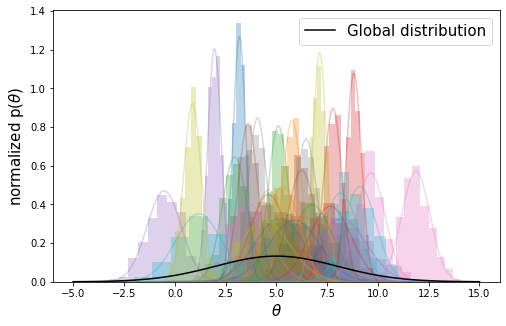

In [3]:
seed = np.random.seed(40)

# define population distribution and draw from it, assign sigmas (randomly between [0.5,1])
x = np.linspace(-5,15,1000)
n = 30
mu_pop, sig_pop = (5,3)
pop = np.random.normal(mu_pop, sig_pop, n)
sigs = np.random.rand(n)+0.3

# generate chains from the posteriors and define the prior on the mean of the population
chains = np.array([np.random.normal(loc=pop[i],scale=sigs[i],size=500) for i in range(n)])
prior = [-5,15]


# plot individual distributions
plt.figure(figsize=(8,5))
x = np.linspace(-5,15,1000)
[plt.plot(x, norm.pdf(x,loc=pop[i], scale=sigs[i]), alpha=0.3, c=f'C{i}') for i in range(n)]

# plot chains
[plt.hist(chains[i],alpha=0.3,density=True, color=f'C{i}') for i in range(n)]

#plot global distribution that they were drawn from
plt.plot(x,norm.pdf(x,mu_pop,sig_pop),c='k',label='Global distribution')

plt.xlabel(r'$\theta$',fontsize=15)
plt.ylabel(r'normalized p($\theta$)',fontsize=15)
plt.legend(fontsize=15)
plt.show()

### Now, use the hierarchical model and the simulated chains to fit for the population mean and spread

100%|██████████████████████████████████████| 3000/3000 [00:19<00:00, 154.89it/s]


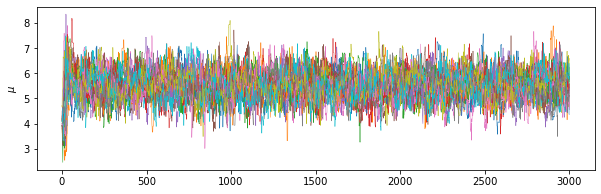

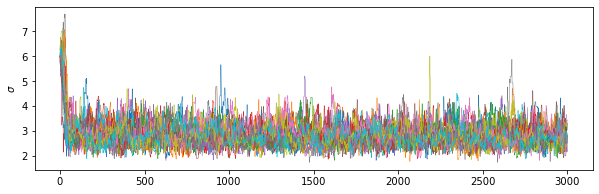

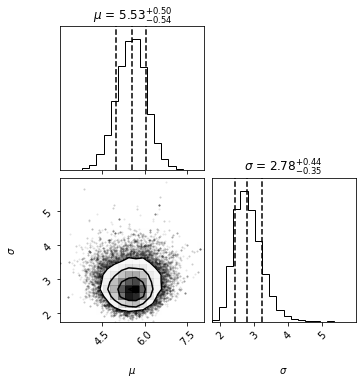

In [4]:
# for this example, mute warnings because they're annoying
import warnings
warnings.filterwarnings('ignore')

nwalkers = 20
ndim = 2
N = 3000
p0 = [4,6]
pos = [p0 + 1e-1*np.random.randn(ndim) for i in range(nwalkers)]

with Pool() as pool:
    backend = emcee.backends.HDFBackend('samples.h5')
    backend.reset(nwalkers, ndim)
            
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[[chains, prior]], 
                                            pool=pool,backend=backend)
            
    sampler.run_mcmc(pos, N, progress=True);

mu = sampler.chain[:,:,0]
sig = sampler.chain[:,:,1]

plt.figure(figsize=(10,3))
[plt.plot(np.arange(0,N,1),mu[i][0:N],linewidth=0.5) for i in range(nwalkers)]
plt.ylabel(r'$\mu$')
plt.show()

plt.figure(figsize=(10,3))
[plt.plot(np.arange(0,N,1),sig[i][0:N],linewidth=0.5) for i in range(nwalkers)]
plt.ylabel(r'$\sigma$')
plt.show()

samples = sampler.chain[:, 400:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$\mu$", "$\sigma$"], show_titles = True, quantiles = [.16,.50,.84])
plt.show()

### Let's check if we were able to retrieve the original normal distribution!

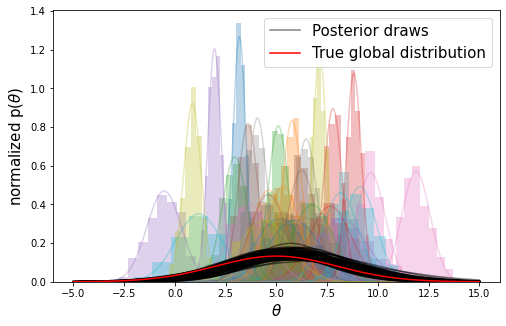

In [5]:
# plot individual distributions
plt.figure(figsize=(8,5))
[plt.plot(x, norm.pdf(x,loc=pop[i], scale=sigs[i]), alpha=0.3, c=f'C{i}') for i in range(n)]

# plot chains
[plt.hist(chains[i],alpha=0.3,density=True, color=f'C{i}') for i in range(n)]

plt.xlabel(r'$\theta$',fontsize=15)
plt.ylabel(r'normalized p($\theta$)',fontsize=15)

mu_pop_fit, sig_pop_fit = np.median(sampler.chain[:, 400:, 0]), np.median(sampler.chain[:, 400:, 1])

for i, (mui, sigi) in enumerate(samples[np.random.randint(len(samples), size=100)]):
    if i == 0:
        plt.plot(x, norm.pdf(x,loc=mui,scale=sigi), color="k", alpha=0.5, label='Posterior draws')
    else:
        plt.plot(x, norm.pdf(x,loc=mui,scale=sigi), color="k", alpha=0.5)
    
    
#plot global distribution that they were drawn from
plt.plot(x,norm.pdf(x,mu_pop,sig_pop),c='r',label='True global distribution')
    
plt.legend(fontsize=15)
plt.show()

### Result

As we can see, the black lines (draws from posteriors of the MCMC fit) match well with the true original global distribution! As the nubmer of galaxies increases (here I only simulated N=30), the uncertainty gets smaller and smaller.

# Next I simulate the linear regression model

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import logsumexp
import emcee
import multiprocessing as mp
import corner
Pool = mp.get_context('fork').Pool # instread of multiprocessing.Pool, this allows global variables to be shared


def model(x, M, beta0, beta1, sig):
    return np.array([np.log(norm.pdf(x[i],beta1*M[i]+beta0,sig)) for i in range(len(x))])


def lnlike(theta, x):
    data, masses, priors = x
    beta0, beta1, sig = theta
    over_chains = logsumexp(model(data, masses, beta0, beta1, sig),axis=1)
    logL = np.sum(over_chains)
    return(logL)

def lnprior(theta,prior):
    beta0, beta1, sig = theta
    range_prior = np.diff(prior)
    
    if (-1< beta1 < 1.5) and (0.01 < sig < range_prior) and \
        (-0.4 < beta0 < 0.5): return 1.0
    
    return -np.inf

def lnprob(theta, x):
    lp = lnprior(theta,x[2]) # x[1] is the prior argument
    if not np.isfinite(lp):
        return -np.inf
    return lp*lnlike(theta, x)
          
          

## Simulate the data

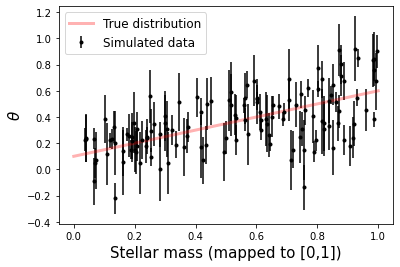

In [7]:
seed = np.random.seed(128)

# define population distribution and draw from it, assign sigmas (randomly between [0.5,1])
x0 = np.linspace(0,1,1000)
n = 130
beta0_pop, beta1_pop, sig_pop = (0.1, 0.5, 0.3)
# beta0_pop, beta1_pop, sig_pop = (0.1, 1, 0.2)

masses = np.sort(np.random.rand(n))
yerr = 0.05 + 0.2 * np.random.rand(n)
y = beta1_pop * masses + beta0_pop
y += np.abs(sig_pop * y) * np.random.randn(n)
y += yerr * np.random.randn(n)

plt.errorbar(masses,y,yerr=yerr,fmt='.k',capsize=0,label='Simulated data')
plt.plot(x0, beta1_pop * x0 + beta0_pop, "r", alpha=0.3, lw=3, label='True distribution')
plt.xlabel('Stellar mass (mapped to [0,1])',fontsize=15)
plt.ylabel(r'$\theta$',fontsize=15)
plt.legend(fontsize=12);


# generate chains from the posteriors and define the prior on the mean of the population
chains = np.array([np.random.normal(loc=y[i],scale=yerr[i],size=500) for i in range(n)])
prior = [-0.5,1.5]

## MCMC fit for the slope and intercept

In [8]:
# for this example, mute warnings because they're annoying
import warnings
warnings.filterwarnings('ignore')

nwalkers = 20
ndim = 3
N = 3000
p0 = [0.15, 0.4, 0.4]
pos = [p0 + 1e-1*np.random.randn(ndim) for i in range(nwalkers)]

with Pool() as pool:
    backend = emcee.backends.HDFBackend('samples.h5')
    backend.reset(nwalkers, ndim)
            
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[[chains, masses, prior]], 
                                            pool=pool,backend=backend)
            
    sampler.run_mcmc(pos, N, progress=True);


100%|███████████████████████████████████████| 3000/3000 [01:49<00:00, 27.34it/s]


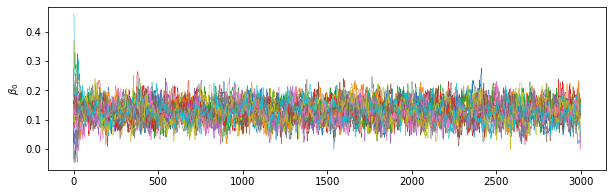

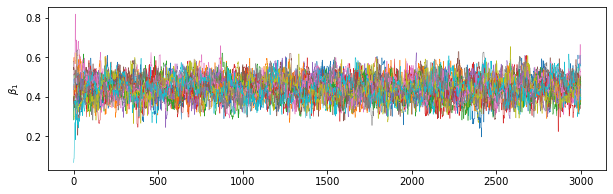

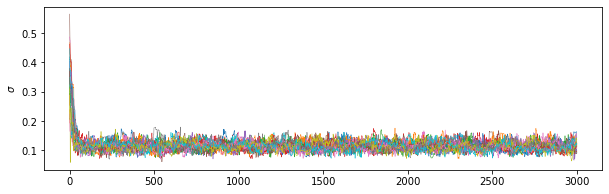

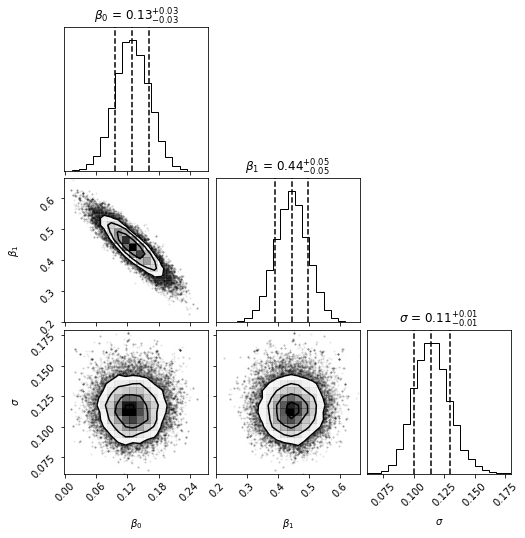

In [9]:
beta0 = sampler.chain[:,:,0]
beta1 = sampler.chain[:,:,1]
sig = sampler.chain[:,:,2]

plt.figure(figsize=(10,3))
[plt.plot(np.arange(0,N,1),beta0[i][0:N],linewidth=0.5) for i in range(nwalkers)]
plt.ylabel(r'$\beta_0$')
plt.show()

plt.figure(figsize=(10,3))
[plt.plot(np.arange(0,N,1),beta1[i][0:N],linewidth=0.5) for i in range(nwalkers)]
plt.ylabel(r'$\beta_1$')
plt.show()

plt.figure(figsize=(10,3))
[plt.plot(np.arange(0,N,1),sig[i][0:N],linewidth=0.5) for i in range(nwalkers)]
plt.ylabel(r'$\sigma$')
plt.show()

samples = sampler.chain[:, 400:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=[r"$\beta_0$", r"$\beta_1$", r"$\sigma$"], show_titles = True, quantiles = [.16,.50,.84])
plt.show()

## Check if I can reproduce the original trend

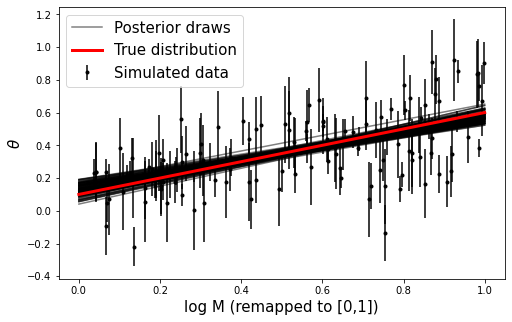

In [10]:
# plot individual distributions
plt.figure(figsize=(8,5))
plt.errorbar(masses,y,yerr=yerr,fmt='.k',capsize=0,label='Simulated data')

for i, (b0, b1,s) in enumerate(samples[np.random.randint(len(samples), size=100)]):
    if i == 0:
        plt.plot(x0, b1*x0+b0, color="k", alpha=0.5, label='Posterior draws')
    else:
        plt.plot(x0, b1*x0+b0, color="k", alpha=0.5)
    
    
plt.plot(x0, beta1_pop * x0 + beta0_pop, "r", lw=3, label='True distribution',zorder=10)
plt.xlabel('log M (remapped to [0,1])',fontsize=15)
plt.ylabel(r'$\theta$',fontsize=15)
plt.legend(fontsize=15)
plt.show()

### From the above, it is clear that we have successfully reproduced the original trend!

# Apply model to actual data

Thinned chains from actual fits to spectra can be found in directory `chains/`

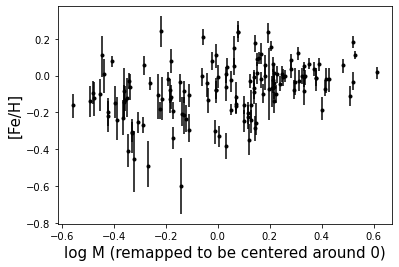

In [11]:
from aliza_read_alf import *
from astropy.table import vstack

a = Table.read('summary_table.fits')

masses = a['lmass_corr'] - 11
plt.errorbar(masses,a['feh'],yerr=[a['feh-'],a['feh+']],fmt='.k')
plt.xlabel('log M (remapped to be centered around 0)',fontsize=15)
plt.ylabel('[Fe/H]',fontsize=15)
plt.show()

In [12]:
# save the chains for [Fe/H] into variable chains
chains = []
for sid in a['SPECT_ID']:
    o = Alf(f'chains/LEGAC.{sid}_thin')
    chains.append(o.mcmc[:,4]+o.mcmc[:,5])
chains = np.array(chains)

## Fit the data with linear model!

In [13]:
# for this example, mute warnings because they're annoying
import warnings
warnings.filterwarnings('ignore')

nwalkers = 20
ndim = 3
N = 3000
p0 = [-0.4, 0.4, 0.3]
pos = [p0 + 1e-1*np.random.randn(ndim) for i in range(nwalkers)]


prior = [-1,1]
with Pool() as pool:
    backend = emcee.backends.HDFBackend('samples.h5')
    backend.reset(nwalkers, ndim)
            
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[[chains, masses, prior]], 
                                            pool=pool,backend=backend)
            
    sampler.run_mcmc(pos, N, progress=True);


100%|███████████████████████████████████████| 3000/3000 [01:56<00:00, 25.76it/s]


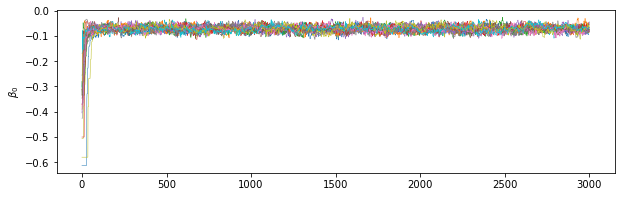

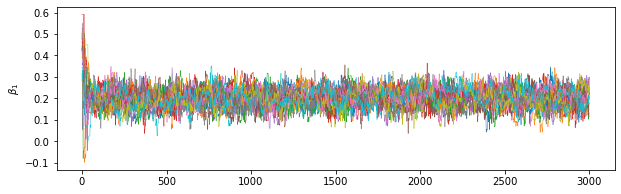

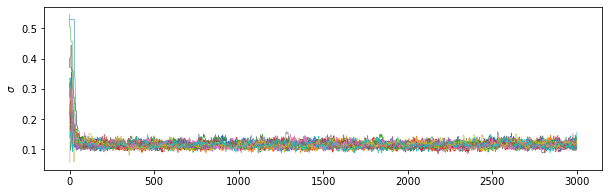

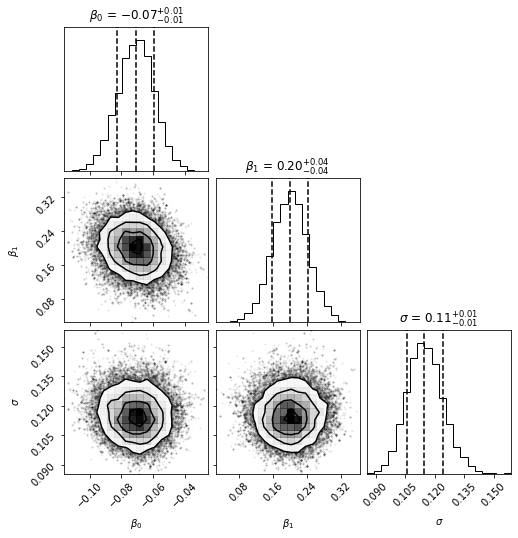

In [14]:
beta0 = sampler.chain[:,:,0]
beta1 = sampler.chain[:,:,1]
sig = sampler.chain[:,:,2]

plt.figure(figsize=(10,3))
[plt.plot(np.arange(0,N,1),beta0[i][0:N],linewidth=0.5) for i in range(nwalkers)]
plt.ylabel(r'$\beta_0$')
plt.show()

plt.figure(figsize=(10,3))
[plt.plot(np.arange(0,N,1),beta1[i][0:N],linewidth=0.5) for i in range(nwalkers)]
plt.ylabel(r'$\beta_1$')
plt.show()

plt.figure(figsize=(10,3))
[plt.plot(np.arange(0,N,1),sig[i][0:N],linewidth=0.5) for i in range(nwalkers)]
plt.ylabel(r'$\sigma$')
plt.show()

samples = sampler.chain[:, 400:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=[r"$\beta_0$", r"$\beta_1$", r"$\sigma$"], show_titles = True, quantiles = [.16,.50,.84])
plt.show()

# Check the fit!

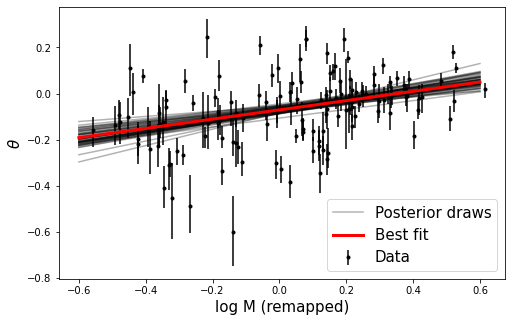

In [15]:
plt.figure(figsize=(8,5))
plt.errorbar(masses,a['feh'],yerr=[a['feh-'],a['feh+']],fmt='.k',label='Data')
plt.xlabel('log M (remapped to be centered around 0)',fontsize=15)
plt.ylabel('[Fe/H]',fontsize=15)

beta0_pop_fit, beta1_pop_fit = np.median(sampler.chain[:, 400:, 0]), np.median(sampler.chain[:, 400:, 1])

x0 = np.linspace(-0.6,0.6,1000)
for i, (b0, b1,s) in enumerate(samples[np.random.randint(len(samples), size=50)]):
    if i == 0:
        plt.plot(x0, b1*x0+b0, color="k", alpha=0.3, label='Posterior draws')
    else:
        plt.plot(x0, b1*x0+b0, color="k", alpha=0.3)
    
    
plt.plot(x0, beta1_pop_fit * x0 + beta0_pop_fit, "r", lw=3, label='Best fit',zorder=10)
plt.xlabel('log M (remapped)',fontsize=15)
plt.ylabel(r'$\theta$',fontsize=15)
plt.legend(fontsize=15)
plt.show()

# Nice! It works! 

This project has forced me to figure this hierarchical bayesian modeling thing, and now that I have it working, I will use it in my next paper! So... thanks! Also thanks for a great semester. I learned a lot and I'm looking forward to applying it to future projects.